# Python: Potential Quantiles
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate potential quantiles and quantile treatment effects. The estimation is based on the article from [Kallus  et al.](https://arxiv.org/abs/1912.12945)

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

The data is generated as a location scale model with

$$Y_i = \text{loc}(D_i,X_i) + \text{scale}(D,X)\cdot\varepsilon_i,$$

where $Xi\sim\mathcal{U}[0,1]^{p}$, $D_i\sim \mathcal{B}(1,1/2)$ and $\varepsilon_i \sim \mathcal{N}(0,1)$.
Further, the location and scale are determined according to the following functions

$$\begin{aligned}
\text{location}(d,x) &:= 0.3D + 4dx_4x_1 - 3x_3 \\
\text{scale}(d,x) &:= \sqrt{d/2 + 3dx_1 + 1}
\end{aligned}$$


In [2]:
def f_loc(D, X):
  loc = 0.3*D + 4*D*X[:,4]*2*X[:,1] - 3*X[:,3]
  return loc

def f_scale(D,X):
  scale = np.sqrt(0.5*D + 3*D*X[:,1] + 1)
  return scale


def dgp(n=200, p=5):
    X = np.random.uniform(0,1,size=[n,p])
    D = ((np.random.normal(size=n)) > 0)*1.0
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X) + f_scale(D, X)*epsilon

    return Y, X, D, epsilon

We can calculate the true potential quantile analytically or through simulations. Here, we will just simulate the true quantile for a range of quantiles.

In [3]:
tau_vec = np.arange(0.2,0.9,0.1)
p = 10
n_true = 1000000

_, X_true, _, epsilon_true = dgp(n=n_true, p = p)
D1 = np.ones(n_true)
D0 = np.zeros(n_true)

Y1 = f_loc(D1, X_true) + f_scale(D1, X_true)*epsilon_true
Y0 = f_loc(D0, X_true) + f_scale(D0, X_true)*epsilon_true

Y1_quant = np.quantile(Y1, q=tau_vec)
Y0_quant = np.quantile(Y0, q=tau_vec)

print(Y1_quant)
print(Y0_quant)

[-1.41302785 -0.70691298 -0.0729559   0.55248381  1.21569383  1.96794318
  2.92323137]
[-2.64630873 -2.22083986 -1.85068013 -1.4995291  -1.15041189 -0.77906744
 -0.35361171]


Let us generate $n=500$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [4]:
n = 500
p = 5
Y, X, D, _ = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D)

Next, we can initialize our two machine learning algorithms to train the different classifiers. Then we can initialize the `DoubleMLPQ` objects and call `.fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `.confint()` method.

In [5]:
ml_m = RandomForestClassifier(n_estimators=100)
ml_g = RandomForestClassifier(n_estimators=100)

PQ_0 = np.full((len(tau_vec)), np.nan)
PQ_1 = np.full((len(tau_vec)), np.nan)

ci_PQ_0 = np.full((len(tau_vec),2), np.nan)
ci_PQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    dml_PQ_0 = dml.DoubleMLPQ(obj_dml_data,
                                  ml_g, ml_m,
                                  quantile=tau,
                                  treatment=0,
                                  n_folds=5)
    dml_PQ_1 = dml.DoubleMLPQ(obj_dml_data,
                                  ml_g, ml_m,
                                  quantile=tau,
                                  treatment=1,
                                  n_folds=5)
    dml_PQ_0.fit()
    dml_PQ_1.fit()

    ci_PQ_0[idx_tau, :] = dml_PQ_0.confint(level=0.95).to_numpy()
    ci_PQ_1[idx_tau, :] = dml_PQ_1.confint(level=0.95).to_numpy()

    PQ_0[idx_tau] = dml_PQ_0.coef
    PQ_1[idx_tau] = dml_PQ_1.coef

Finally, let us take a look at the estimated quantiles.

In [6]:
data = {"Quantile": tau_vec, "Y(0)": Y0_quant, "Y(1)": Y1_quant,
        "DML Y(0)": PQ_0, "DML Y(1)": PQ_1,
        "DML Y(0) lower": ci_PQ_0[:, 0], "DML Y(0) upper": ci_PQ_0[:, 1],
        "DML Y(1) lower": ci_PQ_1[:, 0], "DML Y(1) upper": ci_PQ_1[:, 1]}
df = pd.DataFrame(data)
print(df)

   Quantile      Y(0)      Y(1)  DML Y(0)  DML Y(1)  DML Y(0) lower  \
0       0.2 -2.646309 -1.413028 -2.820785 -1.088042       -3.070218   
1       0.3 -2.220840 -0.706913 -2.239670 -0.412229       -2.493664   
2       0.4 -1.850680 -0.072956 -1.998583  0.144293       -2.253055   
3       0.5 -1.499529  0.552484 -1.655065  0.675131       -1.909188   
4       0.6 -1.150412  1.215694 -1.233497  1.096705       -1.491108   
5       0.7 -0.779067  1.967943 -0.935057  1.804232       -1.198572   
6       0.8 -0.353612  2.923231 -0.548448  2.679999       -0.835541   

   DML Y(0) upper  DML Y(1) lower  DML Y(1) upper  
0       -2.571351       -1.565011       -0.611073  
1       -1.985676       -0.810185       -0.014274  
2       -1.744111       -0.242262        0.530848  
3       -1.400943        0.327965        1.022297  
4       -0.975886        0.707967        1.485442  
5       -0.671542        1.311384        2.297080  
6       -0.261354        2.056516        3.303482  


Text(0.02, 0.5, 'Potential Quantile and 95%-CI')

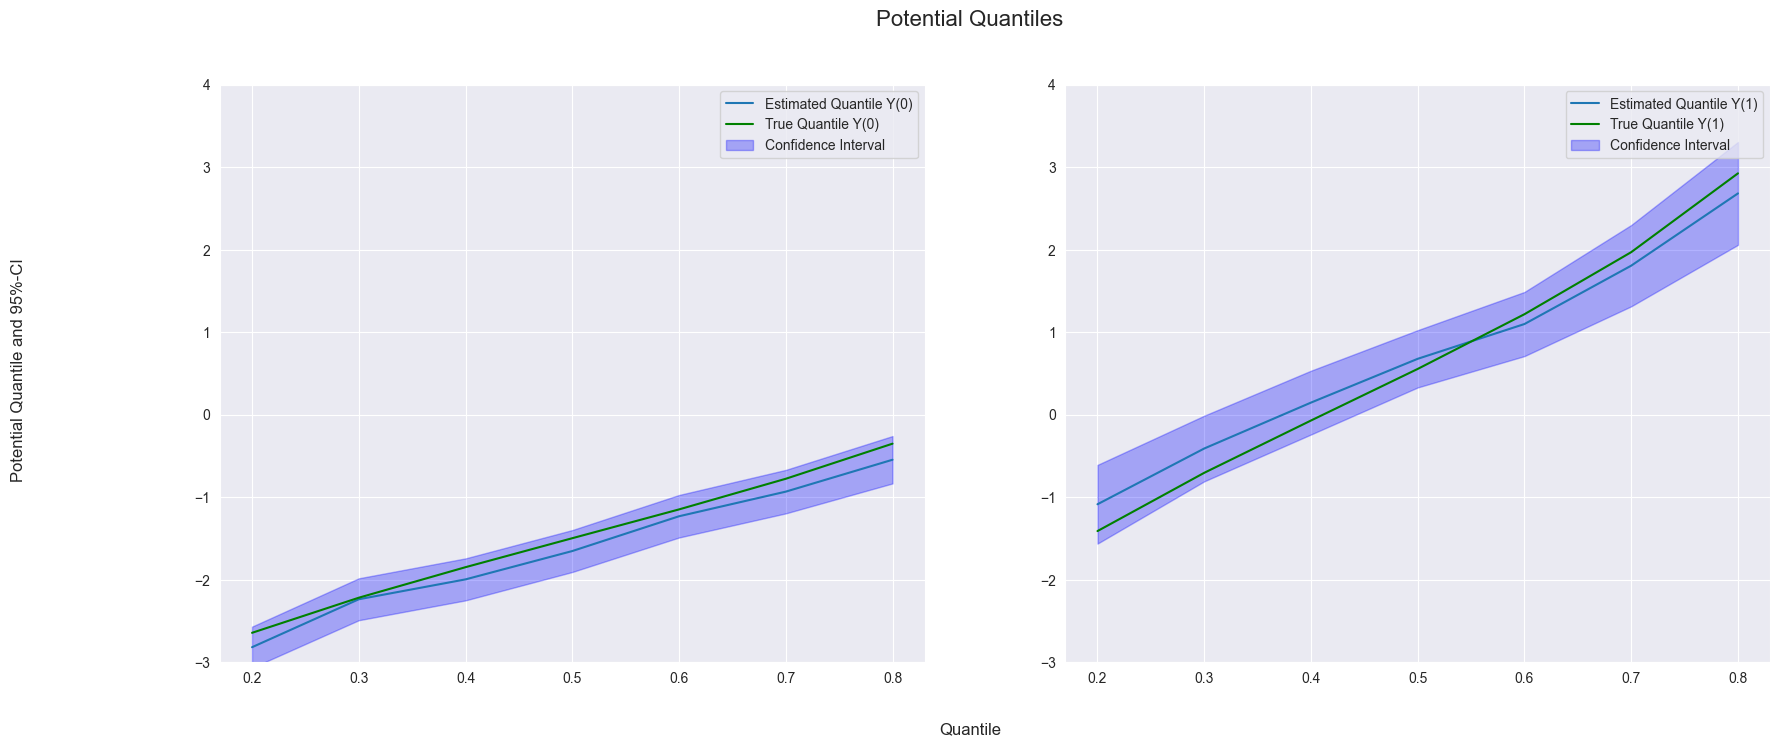

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)

ax1.plot(df['Quantile'],df['DML Y(0)'], label='Estimated Quantile Y(0)')
ax1.plot(df['Quantile'],df['Y(0)'], color="green", label='True Quantile Y(0)')
ax1.fill_between(df['Quantile'], df['DML Y(0) lower'], df['DML Y(0) upper'], color='b', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-3, 4)

ax2.plot(df['Quantile'],df['DML Y(1)'], label='Estimated Quantile Y(1)')
ax2.plot(df['Quantile'],df['Y(1)'], color="green", label='True Quantile Y(1)')
ax2.fill_between(df['Quantile'], df['DML Y(1) lower'], df['DML Y(1) upper'], color='b', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-3, 4)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
fig.supylabel('Potential Quantile and 95%-CI')

To estimate the quantile treatment effect

In [ ]:
dml_QTE = dml.DoubleMLQTE(obj_dml_data,
                      ml_g, ml_m,
                      quantiles=tau_vec,
                      n_rep=1,
                      n_folds=5)
dml_QTE.fit()
QTE_est = dml_QTE.coef
print(QTE_est)

In [ ]:
dml_QTE.bootstrap(n_rep_boot=2000)
ci_QTE= dml_QTE.confint(level=0.95, joint=True).to_numpy()

In [ ]:
QTE = Y1_quant - Y0_quant
data = {"Quantile": tau_vec, "QTE": QTE, "DML QTE": QTE_est,
        "DML QTE lower": ci_QTE[:, 0], "DML QTE upper": ci_QTE[:, 1]}
df = pd.DataFrame(data)
print(df)

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20., 7.5
fig, ax = plt.subplots()

ax.plot(df['Quantile'],df['DML QTE'], label='Estimated QTE')
ax.plot(df['Quantile'],df['QTE'], color="green", label='True QTE')
ax.fill_between(df['Quantile'], df['DML QTE lower'], df['DML QTE upper'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ =  plt.ylabel('QTE and 95%-CI')